# DEM from AIA Data

Invert AIA data to get EM distribution and EM slope map

Do this for two different cases:

- AIA FOV
- EIS FOV

Save an EM slope map for each FOV and each AR. In each case, we'll pick the time that most closely corresponds to the EIS raster

In [1]:
import asdf
import astropy.table
import astropy.units as u
import eispac.core
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import pathlib
import sunpy.map

from astropy.visualization import ImageNormalize, LogStretch
from astropy.nddata import StdDevUncertainty
from ndcube.wcs.tools import unwrap_wcs_to_fitswcs

from sunkit_dem import Model
from synthesizAR.instruments.sdo import _TEMPERATURE_RESPONSE as aia_temperature_response

import sys
sys.path.append('../scripts')
from dem import HK12Model, write_cube_with_xarray, make_slope_map, read_cube_with_xarray

In [2]:
ar_table = astropy.table.QTable.read('../data/tables/mason_ars_region_1.asdf')

In [3]:
channel_list = ['94','131','171','193','211','335']

Build response kernels

In [4]:
kernels = {f'aia_{channel}': aia_temperature_response[channel] for channel in channel_list}
kernel_temperature = aia_temperature_response['temperature']

Build collections of maps at the observation midpoint

In [5]:
# Update collection
def build_aia_collection(top_dir, ref_date, error_percentage=0.1):
    top_dir = pathlib.Path(top_dir)
    collection = []
    for channel in ['94','131','171','193','211','335']:
        file_list = sorted(top_dir.glob(f'aia.lev2*.{channel}.image.fits'))
        maps = sunpy.map.Map(file_list)
        dates = astropy.time.Time([m.meta['t_obs'] for m in maps])
        i_ref = np.argmin(np.fabs((dates - ref_date).to_value('s')))
        print(i_ref)
        m_aia = maps[i_ref]
        m_aia.mask = np.isnan(m_aia.data)
        data = np.where(m_aia.data<0,0,m_aia.data)
        collection.append((f'aia_{channel}', ndcube.NDCube(data,
                                                           wcs=m_aia.wcs,
                                                           meta=m_aia.meta,
                                                           unit=m_aia.unit/u.pix,
                                                           mask=m_aia.mask,
                                                           uncertainty=error_percentage*data,)))
    return ndcube.NDCollection(collection, aligned_axes=(0,1))

In [6]:
delta_log_t = 0.1
temperature_bin_edges = 10**np.arange(5.5, 7.0+delta_log_t, delta_log_t) * u.K

In [7]:
dem_settings = {
    'alpha': 1.25,
    'increase_alpha': 1.5,
    'max_iterations': 100,
    'use_em_loci': False,
    'emd_int': False,
    'l_emd': False,
    'guess': 1,
}
slope_fitting_params = {
    'temperature_bounds': (.9,3)*u.MK,
    'em_threshold': 1e24*u.cm**(-5),
    'rsquared_tolerance': 0.7,
}

In [8]:
root_dir = pathlib.Path('../data/')

In [9]:
for row in ar_table:
    print(row['NOAA AR'])
    top_dir = root_dir / f'noaa_{row["NOAA AR"]}'
    em_dir = top_dir / 'diagnostics' / 'dem'
    em_dir.mkdir(exist_ok=True, parents=True)
    for l2_dir in ['level_2', 'level_2_EIS']:
        print(l2_dir)
        fov_label = f'fov{"EIS" if l2_dir=='level_2_EIS' else "AIA"}'
        _collection = build_aia_collection(top_dir / 'AIA' / l2_dir, row['Date mid'])
        dem_model = Model(_collection,
                          kernels,
                          temperature_bin_edges,
                          kernel_temperatures=kernel_temperature,
                          model='hk12')
        dem_res = dem_model.fit(**dem_settings)
        dem_res['em'].mask = dem_res['dem'].mask
        write_cube_with_xarray(dem_res['em'],
                               'temperature',
                               em_dir / f'em_noaa{row["NOAA AR"]}_{fov_label}.nc')
        slope_map = make_slope_map(dem_res['em'], **slope_fitting_params)
        with asdf.AsdfFile({'slope_map': slope_map}) as asdf_file:
            asdf_file.write_to(em_dir / f'emslope_noaa{row["NOAA AR"]}_{fov_label}.asdf')

11944
level_2
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200

level_2_EIS
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


 20%|████████████████████████▊                                                                                                      | 120/614 [00:01<00:06, 76.7 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
 24%|█████████████████████████████▉                                                                                                 | 145/614 [00:02<00:06, 76.5 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: d

11967
level_2
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


  0%|                                                                                                                                   | 0.00/5.98k [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  3%|███▏                                                                                                                         | 152/5.98k [00:02<01:38, 59.3 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: d

level_2_EIS
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


 43%|███████████████████████████████████████████████████████                                                                        | 266/614 [00:03<00:05, 66.8 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py

11990
level_2
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


  0%|▎                                                                                                                           | 14.0/4.87k [00:00<01:28, 54.6 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  1%|█▎                                                                                                                          | 52.0/4.87k [00:00<01:17, 61.8 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: d

level_2_EIS
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
360
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


 18%|███████████████████████                                                                                                       | 22.0/120 [00:00<00:02, 44.7 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py

In [16]:
with asdf.AsdfFile({'slope_map': slope_map}) as asdf_file:
    asdf_file.write_to(em_dir / f'emslope_noaa{row["NOAA AR"]}_{fov_label}.asdf')

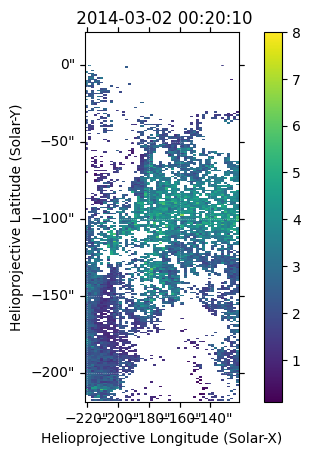

In [19]:
with asdf.open('../data/noaa_11990/diagnostics/dem/emslope_noaa11990_fovEIS.asdf', lazy_load=False) as af:
    _sm = af['slope_map']
#_sm.mask = None
_sm.peek(vmax=8, cmap='viridis', aspect=_sm.scale[1]/_sm.scale[0])

Now try to fit the EM slopes

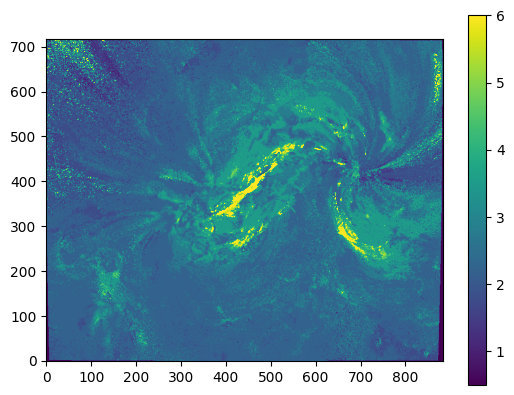

In [23]:
plt.imshow(dem_model_11944.temperature_bin_centers[np.argmax(dem_res_11944['em'].data, axis=0)].to_value('MK'),
           vmin=.5,vmax=6, origin='lower')
plt.colorbar()

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_2887/3770229464.py:43: RuntimeWarning: divide by zero encountered in log10
  em_fit = np.log10(data.value.reshape((np.prod(data.shape[:2]),) + data.shape[2:]).T)
/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_2887/3770229464.py:43: RuntimeWarning: invalid value encountered in log10
  em_fit = np.log10(data.value.reshape((np.prod(data.shape[:2]),) + data.shape[2:]).T)
/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_2887/3770229464.py:51: RuntimeWarning: invalid value encountered in divide
  rsquared = 1. - rss/rss_flat


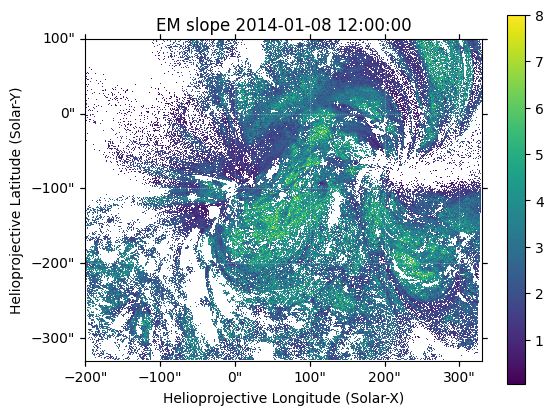

In [43]:
foo = make_slope_map(dem_res_11944['em'], temperature_bounds=(.9,3)*u.MK, em_threshold=1e24*u.cm**(-5), rsquared_tolerance=0.7)
#foo.mask = np.any([foo.mask, foo.data<0], axis=0)
foo.plot(vmax=8, cmap='viridis')
#plt.plot(*np.where(foo.data<0)[::-1], marker='.', color='C1', ls='')
plt.colorbar()

(array([3.04460e+04, 1.55321e+05, 1.28141e+05, 5.50040e+04, 1.29720e+04,
        2.41900e+03, 3.81000e+02, 5.80000e+01, 9.00000e+00, 3.00000e+00]),
 array([ 0.        ,  1.28245674,  2.56491348,  3.84737021,  5.12982695,
         6.41228369,  7.69474043,  8.97719716, 10.2596539 , 11.54211064,
        12.82456738]),
 <BarContainer object of 10 artists>)

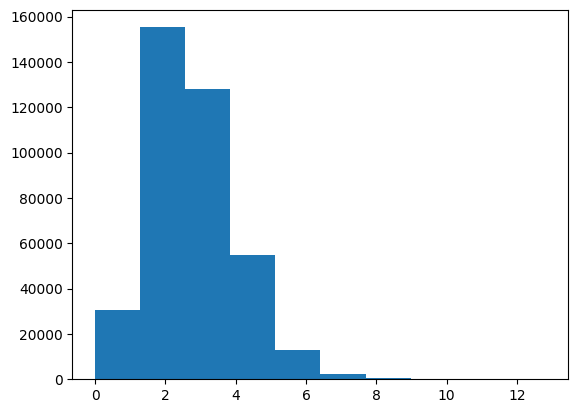

In [33]:
plt.hist(foo.data[~foo.mask],log=False)